In [1]:
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import sklearn.ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
# import eli5
# from eli5.sklearn import PermutationImportance

%matplotlib inline

C:\Users\csong\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# machine learning
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, r2_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from boruta import BorutaPy
from xgboost import XGBClassifier, XGBRanker
from scipy.stats import skew


# print(__doc__)

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
## Load the data set that got dummified to process feature selection.
train= pd.read_csv('./data/Xing/whole_train_cleaned_15.csv')
test= pd.read_csv('./data/Xing/unique_test_cleaned_15.csv')

X_train= train.drop(['readmitted','encounter_id','patient_nbr'], axis=1)
y_train= train['readmitted']



X_test = test.drop(['readmitted','encounter_id','patient_nbr'], axis=1)
y_test = test['readmitted']


print("Dataset: Unique- Drop Patient encounter ID")
print('The shape of the unique train dataset {}'.format(train.shape))
print('The shape of the unique test dataset  {} '.format(test.shape))

Dataset: Unique- Drop Patient encounter ID
The shape of the unique train dataset (84422, 94)
The shape of the unique test dataset  (13835, 94) 


# Logistic Regression

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(fit_intercept=True, penalty='l1')
logreg.fit(X_train, y_train)
print("Train set Score: {:.2%}".format(logreg.score(X_train, y_train)))
print("Test Set score : {:.2%}".format(logreg.score(X_test, y_test)))

Train set Score: 88.63%
Test Set score : 89.37%


- Highly overfitting.

In [5]:
y_test_predict = logreg.predict(X_test)

In [6]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,12351,17,12368
1,1453,14,1467
All,13804,31,13835


In [7]:
# Print Classification Report
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     12368
          1       0.45      0.01      0.02      1467

avg / total       0.85      0.89      0.85     13835



In [8]:
from sklearn.metrics import confusion_matrix

tp, fp, fn, tn = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

12351 17 1453 14


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.894
Precision is 0.452
Recall is 0.010
AUC is 0.504
TPR is 0.895
FPR is 0.548
TNR is 0.452


In [10]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

In [11]:
coef_base=pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_)),columns=['Features','Coefficients']).sort_values(by='Coefficients',ascending=False)

In [12]:
coef_base.head(10)

,Features,Coefficients
72,acarbose_Up,[0.5112041325270925]
46,repaglinide_Up,[0.48129506578913145]
21,discharge_disposition_id_hospital,[0.37991252426069816]
7,number_inpatient,[0.2682228950511495]
90,diabetesMed_Yes,[0.21335313987121604]
39,A1Cresult_None,[0.16581809048347876]
61,glyburide_Steady,[0.1287079148409978]
62,glyburide_Up,[0.11892789600518551]
69,rosiglitazone_Up,[0.07004340585645236]
27,diag_1_diabetes,[0.06386203035343513]


#### Summary( Base Logistic Regression):
  - Classification Error Type II --> The data distribution has highly unbalance between among the train dataset. Thus, we apply SMOTE.

#### Apply SMOTE

In [13]:
# Data balancing applied using SMOTE
from imblearn.over_sampling import SMOTE

from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_SMOTE)))

Original dataset shape Counter({0: 74836, 1: 9586})
New dataset shape Counter({0: 74836, 1: 74836})


In [14]:
#Put the new balanced dataset (Oversampled with SMOTE) in the dataframe
X_train_SMOTE = pd.DataFrame(X_train_SMOTE, columns = list(X_train.columns))

In [15]:
# Run the crossvalidation following by fit the SMOTE balanced data

logreg = LogisticRegression(fit_intercept=True, penalty='l1')
logreg.fit(X_train_SMOTE, y_train_SMOTE)
print("Train set Score: {:.3%}".format(logreg.score(X_train_SMOTE, y_train_SMOTE)))
print("Test Set score : {:.3%}".format(logreg.score(X_test, y_test)))

Train set Score: 62.341%
Test Set score : 66.874%


In [16]:
# Check with the validation testset
y_test_predict = logreg.predict(X_test)
probability = logreg.predict_proba(X_test)

In [17]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,8527,3841,12368
1,742,725,1467
All,9269,4566,13835


In [18]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.92      0.69      0.79     12368
          1       0.16      0.49      0.24      1467

avg / total       0.84      0.67      0.73     13835



In [19]:
from sklearn.metrics import confusion_matrix

tp, fp, fn, tn = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

8527 3841 742 725


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.669
Precision is 0.159
Recall is 0.494
AUC is 0.592
TPR is 0.920
FPR is 0.841
TNR is 0.159


In [21]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

#### Apply 'Class_weight' = balanced

In [22]:
# Turn on Class-weight balance

logreg = LogisticRegression(fit_intercept=True, penalty='l1',class_weight='balanced')
logreg.fit(X_train_SMOTE, y_train_SMOTE)
print("Train set Score: {:.3%}".format(logreg.score(X_train_SMOTE, y_train_SMOTE)))
print("Test Set score : {:.3%}".format(logreg.score(X_test, y_test)))

Train set Score: 62.343%
Test Set score : 66.874%


In [23]:
# Check with the validation testset
y_test_predict = logreg.predict(X_test)
probability = logreg.predict_proba(X_test)

In [24]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,8527,3841,12368
1,742,725,1467
All,9269,4566,13835


In [25]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.92      0.69      0.79     12368
          1       0.16      0.49      0.24      1467

avg / total       0.84      0.67      0.73     13835



In [26]:
from sklearn.metrics import confusion_matrix

tp, fp, fn, tn = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

8527 3841 742 725


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.669
Precision is 0.159
Recall is 0.494
AUC is 0.592
TPR is 0.920
FPR is 0.841
TNR is 0.159


In [28]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

In [29]:
coef_SMOTE=pd.DataFrame(zip(X_train_SMOTE.columns, np.transpose(logreg.coef_)),columns=['Features','Coefficients']).sort_values(by='Coefficients',ascending=False)

In [30]:
coef_SMOTE.head(10)

,Features,Coefficients
72,acarbose_Up,[0.826266839464646]
48,nateglinide_Steady,[0.5219617264284762]
68,rosiglitazone_Steady,[0.5069323185116376]
61,glyburide_Steady,[0.486424309803471]
46,repaglinide_Up,[0.4668197648812866]
45,repaglinide_Steady,[0.42439323734352813]
90,diabetesMed_Yes,[0.3819333140338008]
21,discharge_disposition_id_hospital,[0.37349569509936614]
7,number_inpatient,[0.2998619068655616]
9,med_dosage_change,[0.2825495807554257]


#### Apply RandomizedSearch

In [31]:
# Apply randomizedsearch to find the optimum "C"

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_train_SMOTE, y_train_SMOTE)
search.best_params_


{'C': 3.3770629943240693, 'penalty': 'l1'}

In [32]:
logreg = LogisticRegression(fit_intercept=True, penalty='l1',class_weight='balanced',C=2.195254015709299)
logreg.fit(X_train_SMOTE, y_train_SMOTE)
print("Train set Score: {:.3%}".format(logreg.score(X_train_SMOTE, y_train_SMOTE)))
print("Test Set score : {:.3%}".format(logreg.score(X_test, y_test)))

Train set Score: 62.348%
Test Set score : 66.867%


In [33]:
# Check with the validation testset
y_test_predict = logreg.predict(X_test)
probability = logreg.predict_proba(X_test)

In [34]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,8526,3842,12368
1,742,725,1467
All,9268,4567,13835


In [35]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.92      0.69      0.79     12368
          1       0.16      0.49      0.24      1467

avg / total       0.84      0.67      0.73     13835



In [36]:
from sklearn.metrics import confusion_matrix

tp, fp, fn, tn = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

8526 3842 742 725


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.669
Precision is 0.159
Recall is 0.494
AUC is 0.592
TPR is 0.920
FPR is 0.841
TNR is 0.159


In [38]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

In [39]:
coef_random_search=pd.DataFrame(zip(X_train_SMOTE.columns, np.transpose(logreg.coef_)),columns=['Features','Coefficients']).sort_values(by='Coefficients',ascending=False)

In [40]:
coef_random_search.head(10)

,Features,Coefficients
72,acarbose_Up,[0.7965221684517673]
48,nateglinide_Steady,[0.7959648949959547]
68,rosiglitazone_Steady,[0.6349006995429598]
46,repaglinide_Up,[0.6037820770537906]
45,repaglinide_Steady,[0.5979692497845741]
61,glyburide_Steady,[0.549564673809621]
47,nateglinide_No,[0.49872409402619866]
90,diabetesMed_Yes,[0.38247677642484895]
21,discharge_disposition_id_hospital,[0.373664460647863]
67,rosiglitazone_No,[0.3429273821689891]


In [41]:
# import statsmodels.api as sm
# logit = sm.Logit(X_train_SMOTE, y_train_SMOTE)

# result = logit.fit()
# print(result.summary())

# Decision Tree Clssifier - "Entropy"

- For this decision tree classifier, I developed the model based on the reference model (logistic regression with SMOTE)

In [42]:
# Data balancing applied using SMOTE
from imblearn.over_sampling import SMOTE

from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
X_train_SMOTE_dt, y_train_SMOTE_dt = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_SMOTE_dt)))

Original dataset shape Counter({0: 74836, 1: 9586})
New dataset shape Counter({0: 74836, 1: 74836})


In [43]:
from sklearn.tree import DecisionTreeClassifier
dt_en = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dt_en.fit(X_train_SMOTE_dt, y_train_SMOTE_dt)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=28,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
print("Train set Score: {:.3%}".format(dt_en.score(X_train, y_train)))
print("Test Set score : {:.3%}".format(dt_en.score(X_test, y_test)))

Train set Score: 93.628%
Test Set score : 83.708%


In [45]:
y_test_predict = dt_en.predict(X_test)

In [46]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,11390,978,12368
1,1276,191,1467
All,12666,1169,13835


In [47]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.90      0.92      0.91     12368
          1       0.16      0.13      0.14      1467

avg / total       0.82      0.84      0.83     13835



In [48]:
from sklearn.metrics import confusion_matrix

tp, fp, fn, tn = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

11390 978 1276 191


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.837
Precision is 0.163
Recall is 0.130
AUC is 0.526
TPR is 0.899
FPR is 0.837
TNR is 0.163


In [50]:
accuracy_dt_en = accuracy_score(y_test, y_test_predict)
precision_dt_en = precision_score(y_test, y_test_predict)
recall_dt_en = recall_score(y_test, y_test_predict)
auc_dt_en = roc_auc_score(y_test, y_test_predict)
TPR_dt_en=TPR
FPR_ldt_en=FPR
TNR_dt_en=TNR

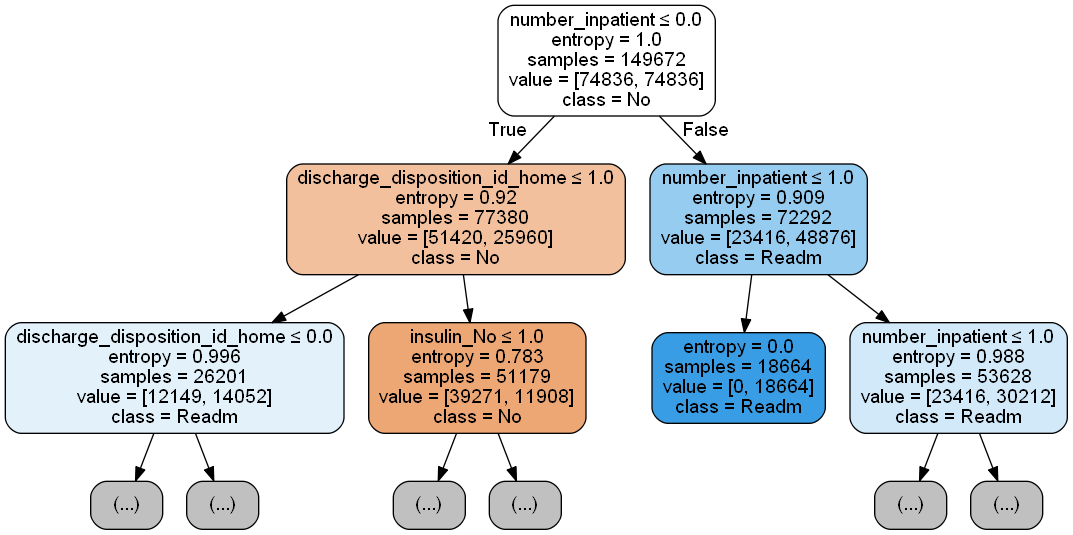

In [51]:
# Visualizaing decision tree for Question 2 - detailed feature set
import graphviz
from IPython.display import Image
import pydotplus
from sklearn import tree
dot_dt_q2 = tree.export_graphviz(dt_en, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2,
                                 class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
Image(graph_dt_q2.create_png())

                          Feature  Importance
19       admission_type_id_urgent       0.020
8                number_diagnoses       0.022
1                time_in_hospital       0.022
4                 num_medications       0.031
16                    gender_Male       0.035
12                 race_Caucasian       0.037
2              num_lab_procedures       0.041
79                     insulin_No       0.065
20  discharge_disposition_id_home       0.138
7                number_inpatient       0.345


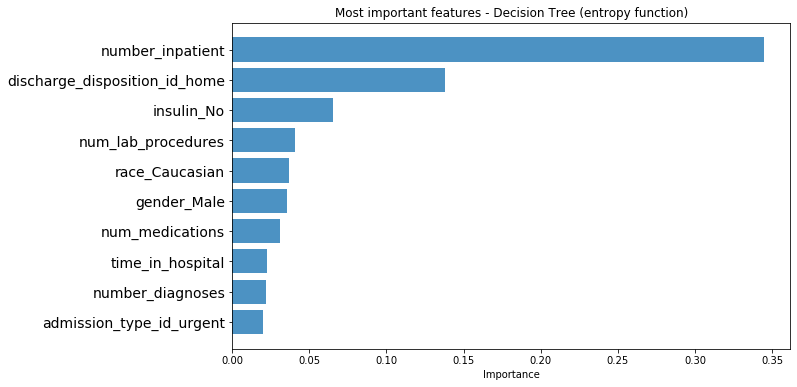

In [52]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dt_en.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree (entropy function)')
plt.show()

# Decision Tree Classifier : "Gini"

In [53]:
from sklearn.tree import DecisionTreeClassifier
dt_g = DecisionTreeClassifier(max_depth=28, criterion = "gini", min_samples_split=10)
dt_g.fit(X_train_SMOTE_dt, y_train_SMOTE_dt)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=28,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
print("Train set Score: {:.3%}".format(dt_g.score(X_train_SMOTE_dt, y_train_SMOTE_dt)))
print("Test Set score : {:.3%}".format(dt_g.score(X_test, y_test)))

Train set Score: 96.094%
Test Set score : 84.019%


In [55]:
y_test_predict = dt_g.predict(X_test)

In [56]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,11451,917,12368
1,1294,173,1467
All,12745,1090,13835


In [57]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.90      0.93      0.91     12368
          1       0.16      0.12      0.14      1467

avg / total       0.82      0.84      0.83     13835



In [58]:
from sklearn.metrics import confusion_matrix

tp, fp, fn, tn = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

11451 917 1294 173


In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.840
Precision is 0.159
Recall is 0.118
AUC is 0.522
TPR is 0.898
FPR is 0.841
TNR is 0.159


In [60]:
accuracy_dt_g = accuracy_score(y_test, y_test_predict)
precision_dt_g = precision_score(y_test, y_test_predict)
recall_dt_g = recall_score(y_test, y_test_predict)
auc_dt_g = roc_auc_score(y_test, y_test_predict)

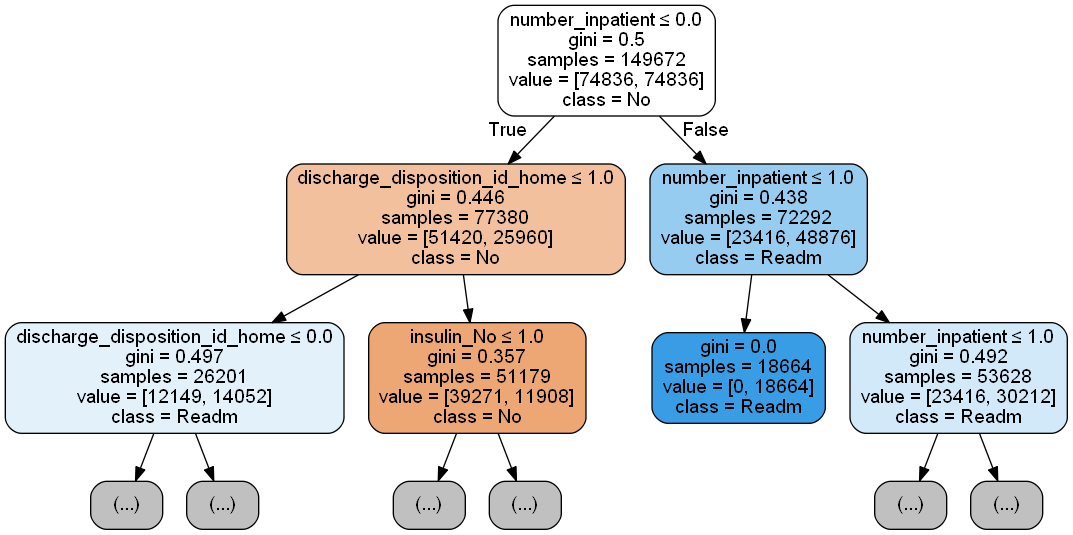

In [61]:
# Visualizaing decision tree for Question 2 - detailed feature set
import graphviz
from IPython.display import Image
import pydotplus
from sklearn import tree
dot_dt_q2 = tree.export_graphviz(dt_g, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2,
                                 class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
Image(graph_dt_q2.create_png())

                              Feature  Importance
21  discharge_disposition_id_hospital       0.019
26         admission_source_id_urgent       0.021
8                    number_diagnoses       0.021
4                     num_medications       0.022
2                  num_lab_procedures       0.026
19           admission_type_id_urgent       0.026
80                     insulin_Steady       0.032
79                         insulin_No       0.070
20      discharge_disposition_id_home       0.154
7                    number_inpatient       0.365


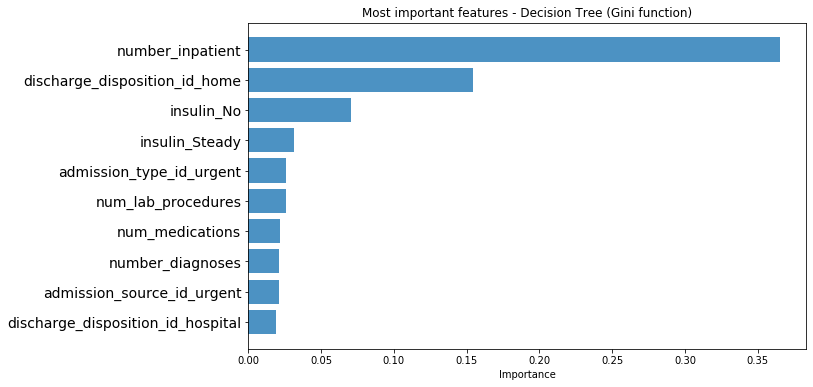

In [62]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dt_g.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree (Gini function)')
plt.show()

# Random Forest Classifier : "Gini"


In [63]:
# Data balancing applied using SMOTE
from imblearn.over_sampling import SMOTE

from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
X_train_SMOTE_rf, y_train_SMOTE_rf = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_SMOTE_rf)))

Original dataset shape Counter({0: 74836, 1: 9586})
New dataset shape Counter({0: 74836, 1: 74836})


In [64]:
from sklearn.ensemble import RandomForestClassifier
rf_gini = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rf_gini.fit(X_train_SMOTE_rf, y_train_SMOTE_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
print("Train set Score: {:.3%}".format(rf_gini.score(X_train_SMOTE_rf, y_train_SMOTE_rf)))
print("Test Set score : {:.3%}".format(rf_gini.score(X_test, y_test)))

Train set Score: 94.362%
Test Set score : 89.252%


In [66]:
y_test_predict = rf_gini.predict(X_test)

In [67]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,12330,38,12368
1,1449,18,1467
All,13779,56,13835


In [68]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     12368
          1       0.32      0.01      0.02      1467

avg / total       0.83      0.89      0.85     13835



In [69]:
from sklearn.metrics import confusion_matrix

tp, fp, fn, tn = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

12330 38 1449 18


In [70]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.893
Precision is 0.321
Recall is 0.012
AUC is 0.505
TPR is 0.895
FPR is 0.679
TNR is 0.321


In [71]:
accuracy_rf_g = accuracy_score(y_test, y_test_predict)
precision_rf_g = precision_score(y_test, y_test_predict)
recall_rf_g = recall_score(y_test, y_test_predict)
auc_rf_g = roc_auc_score(y_test, y_test_predict)

TPR_rf_g=TPR
FPR_rf_g=FPR
TNR_rf_g=TNR

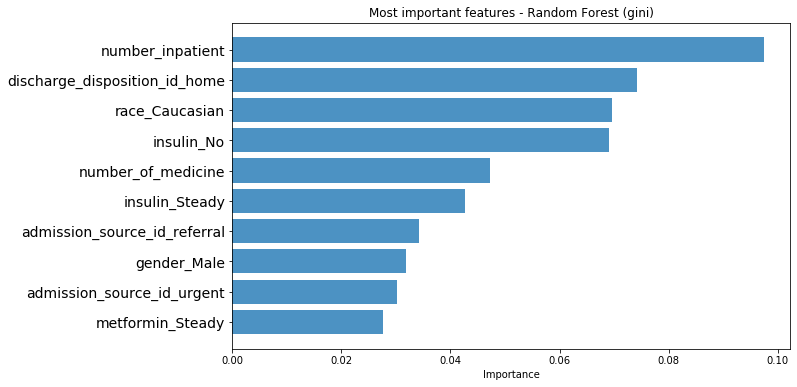

In [72]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rf_gini.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (gini)')
plt.show()

# Random Forest Classifier : "Entropy"


In [73]:
from sklearn.ensemble import RandomForestClassifier
rf_en = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "entropy", min_samples_split=10)
rf_en.fit(X_train_SMOTE_rf, y_train_SMOTE_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [74]:
print("Train set Score: {:.3%}".format(rf_en.score(X_train_SMOTE_rf, y_train_SMOTE_rf)))
print("Test Set score : {:.3%}".format(rf_en.score(X_test, y_test)))

Train set Score: 94.382%
Test Set score : 89.252%


In [75]:
y_test_predict = rf_en.predict(X_test)

In [76]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,12336,32,12368
1,1455,12,1467
All,13791,44,13835


In [77]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     12368
          1       0.27      0.01      0.02      1467

avg / total       0.83      0.89      0.84     13835



In [78]:
from sklearn.metrics import confusion_matrix

tp, fp, fn, tn = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

12336 32 1455 12


In [79]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.893
Precision is 0.273
Recall is 0.008
AUC is 0.503
TPR is 0.894
FPR is 0.727
TNR is 0.273


In [80]:
accuracy_rf_en = accuracy_score(y_test, y_test_predict)
precision_rf_en = precision_score(y_test, y_test_predict)
recall_rf_en = recall_score(y_test, y_test_predict)
auc_rf_en = roc_auc_score(y_test, y_test_predict)

TPR_rf_en=TPR
FPR_rf_en=FPR
TNR_rf_en=TNR

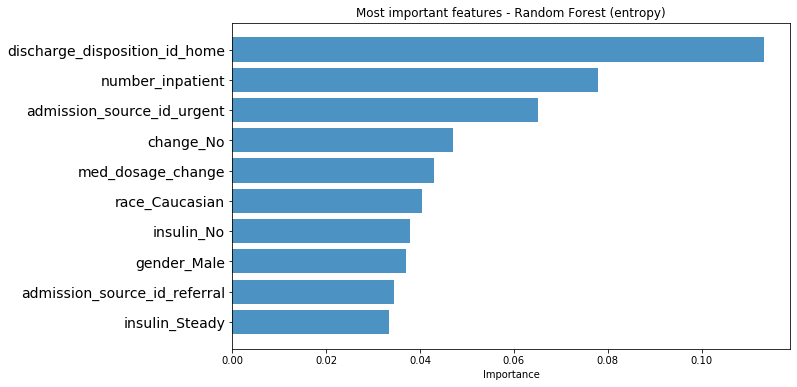

In [81]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rf_en.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (entropy)')
plt.show()